In [20]:
from features import feat_cnt, constant
from text_processing import remove_rows_with_none_elements, clean_text, readJSON, common_grams, bag, get_gram_id,remove_rows_with_none_elements, strip_text,remove_incorrectly_spelled_words
from metrics import measure
from data_process import read_csv
from unsupervised_processing import create_dominant_topics, cluster,count_all_topics
from features import feat_cnt, constant
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import *
import nltk
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score, accuracy_score
import pickle
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danhj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danhj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Read the data, remove rows with None elements and clean the text, convert M and F to 1 and 0
with open('columns.pkl', 'rb') as f:
    columns = pickle.load(f)
with open('correct_spelling_data.pkl', 'rb') as f: 
    correct_spelling_data = pickle.load(f)
with open('incorrect_spelling_count_data.pkl', 'rb') as f:
    incorrect_spelling_data = pickle.load(f)

for i in range(len(correct_spelling_data[0])):
    correct_spelling_data[0][i] = clean_text(correct_spelling_data[0][i])
    
for i in range(len(correct_spelling_data[0])):
    if correct_spelling_data[1][i].lower() == 'm': 
        correct_spelling_data[1][i] = 1
    else:
        correct_spelling_data[1][i] = 0


In [3]:
print(incorrect_spelling_data)


[[[14], [46], [63], [16], [11], [15], [61], [65], [5], [6], [64], [138], [19], [11], [22], [14], [9], [96], [23], [58], [43], [71], [16], [14], [20], [61], [21], [7], [10], [62], [9], [38], [20], [33], [28], [24], [38], [27], [80], [23], [2], [0], [15], [28], [7], [16], [3], [17], [19], [78], [13], [30], [25], [34], [16], [5], [110], [3], [62], [23], [31], [8], [61], [26], [36], [19], [26], [48], [22], [23], [43], [134], [11], [31], [86], [14], [11], [8], [42], [25], [67], [95], [16], [62], [26], [24], [6], [39], [22], [15], [66], [26], [49], [18], [65], [52], [24], [42], [56], [9], [24], [11], [46], [37], [54], [16], [72], [17], [36], [502], [49], [27], [6], [2], [44], [21], [77], [44], [10], [11], [4], [9], [15], [6], [16], [25], [20], [4], [23], [28], [44], [23], [12], [16], [10], [10], [2], [54], [12], [29], [74], [7], [16], [45], [116], [64], [16], [47], [76], [13], [18], [54], [7], [38], [20], [52], [63], [55], [57], [47], [35], [27], [161], [43], [9], [11], [53], [3], [31], [47]

In [27]:
def find_best_clusters(total_topics, top_topics):
  grouped_words, dominate_topics1 = create_dominant_topics((correct_spelling_data[0]), total_topics, top_topics, 30)
  return run_models(grouped_words, correct_spelling_data[0], 'gaussian')

def run_models(input, output, nb_type='gaussian'):
  """
  Runs multiple models for classification and evaluates their performance using cross-validation.

  Parameters:
  input (array-like): The input data for training the models.
  output (array-like): The target variable for training the models.
  nb_type (str, optional): The type of Naive Bayes model to use. Defaults to 'gaussian'.

  Returns:
  tuple: A tuple containing the input and output data.

  """
  blog_train, blog_test, gender_train, gender_test = train_test_split(input, output, test_size=0.2, random_state=27)
  vectorizer = CountVectorizer()

  nb_models = {
    'multinomial': MultinomialNB,
    'bernoulli': BernoulliNB,
    'complement': ComplementNB,
    'gaussian': GaussianNB
  }
  naive_model = nb_models.get(nb_type.lower())()
  logistic_model = LogisticRegression(max_iter=1000)
  dst_model = DecisionTreeClassifier(criterion = 'entropy',random_state=42)
  
  scoring = {'accuracy': make_scorer(accuracy_score)}
  
  score_naive = cross_validate(naive_model, input, correct_spelling_data[1], cv=10, scoring=scoring)
  scores_logistic = cross_validate(logistic_model, input, correct_spelling_data[1], cv=10, scoring=scoring)
  dst_model = cross_validate(dst_model, input, correct_spelling_data[1], cv=10, scoring=scoring)
  # Print the average scores

  score_NB = score_naive['test_accuracy'].mean()
  print("Naive Bayes Average cross-validation accuracy: {:.5f}".format(score_NB))

  score_log = scores_logistic['test_accuracy'].mean()
  print("Logistic Regression Average cross-validation accuracy: {:.5f}".format(score_log))
  
  score_svc = dst_model['test_accuracy'].mean()
  print("DST Average cross-validation accuracy: {:.5f}".format(score_svc))

  return score_NB,score_log, score_svc



def ensemble(input,output):
  # Assuming X is your feature matrix and y are your labels
  X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.2, random_state=42)

  # Create the individual models
  clf1 = ComplementNB()
  clf2 = LogisticRegression(random_state=1,max_iter=1000)
  clf3 = SVC(probability=True, random_state=1,max_iter=10000)

  # Create the first layer of ensemble models
  ensemble1 = VotingClassifier(estimators=[('rf', clf1), ('lr', clf2)], voting='soft')
  ensemble2 = VotingClassifier(estimators=[('rf', clf1), ('svc', clf3)], voting='soft')

  # Create the second layer ensemble model
  eclf = VotingClassifier(estimators=[('e1', ensemble1), ('e2', ensemble2)], voting='hard')

  # Train the ensemble model
  eclf.fit(X_train, y_train)

  # Test the ensemble model
  y_pred = eclf.predict(X_test)
  
  scoring = {'accuracy': make_scorer(accuracy_score)}
  score_ensemble = cross_validate(eclf, input, correct_spelling_data[1], cv=10, scoring=scoring)
  score_EN = score_ensemble['test_accuracy'].mean()
  print("Ensemble cross-validation accuracy: {:.5f}".format(score_EN))


In [29]:
#Algorithm to find best clusters
max_nb, max_log, max_dst = 0,0,0
for i in range(1,40):
  for j in range(i):
    
    if i > 0 and j > 0:  # Check if input data has at least one feature
      print("Total topics: {}, top topics: {}".format(i,j)) 
      grouped_words, _ = create_dominant_topics((correct_spelling_data[0]), i, j, 30)
      score_nb, score_log, score_dst = run_models(grouped_words, correct_spelling_data[0], 'gaussian')

print("MaxNB: {:.5f}, MaxLog: {:.5f}, MaxDST: {:.5f}".format(max_nb, max_log, max_dst)) 


Total topics: 2, top topics: 1
Naive Bayes Average cross-validation accuracy: 0.61346
Logistic Regression Average cross-validation accuracy: 0.61346
SVC Average cross-validation accuracy: 0.61346
Total topics: 3, top topics: 1
Naive Bayes Average cross-validation accuracy: 0.60414
Logistic Regression Average cross-validation accuracy: 0.49906
SVC Average cross-validation accuracy: 0.62429
Total topics: 3, top topics: 2
Naive Bayes Average cross-validation accuracy: 0.55949
Logistic Regression Average cross-validation accuracy: 0.55949
SVC Average cross-validation accuracy: 0.61530
Total topics: 4, top topics: 1
Naive Bayes Average cross-validation accuracy: 0.60630
Logistic Regression Average cross-validation accuracy: 0.60630
SVC Average cross-validation accuracy: 0.62335
Total topics: 4, top topics: 2
Naive Bayes Average cross-validation accuracy: 0.60630
Logistic Regression Average cross-validation accuracy: 0.54246
SVC Average cross-validation accuracy: 0.61158
Total topics: 4, top

KeyboardInterrupt: 

In [24]:
grouped_words, dominate_topics1 = create_dominant_topics((correct_spelling_data[0]), 6, 2, 30)
run_models(grouped_words, correct_spelling_data[0], 'gaussian')


Naive Bayes Average cross-validation accuracy: 0.62120
Logistic Regression Average cross-validation accuracy: 0.61222
SVC Average cross-validation accuracy: 0.63855


([array([1, 0], dtype=int64),
  array([1, 5], dtype=int64),
  array([2, 0], dtype=int64),
  array([1, 5], dtype=int64),
  array([2, 4], dtype=int64),
  array([1, 3], dtype=int64),
  array([5, 2], dtype=int64),
  array([0, 4], dtype=int64),
  array([0, 1], dtype=int64),
  array([5, 0], dtype=int64),
  array([4, 1], dtype=int64),
  array([2, 0], dtype=int64),
  array([2, 4], dtype=int64),
  array([2, 1], dtype=int64),
  array([0, 4], dtype=int64),
  array([0, 3], dtype=int64),
  array([2, 1], dtype=int64),
  array([2, 0], dtype=int64),
  array([0, 3], dtype=int64),
  array([2, 0], dtype=int64),
  array([1, 5], dtype=int64),
  array([2, 4], dtype=int64),
  array([3, 1], dtype=int64),
  array([5, 2], dtype=int64),
  array([5, 2], dtype=int64),
  array([2, 1], dtype=int64),
  array([2, 0], dtype=int64),
  array([1, 0], dtype=int64),
  array([3, 4], dtype=int64),
  array([1, 0], dtype=int64),
  array([4, 1], dtype=int64),
  array([1, 2], dtype=int64),
  array([1, 5], dtype=int64),
  array([1

In [7]:
count_topic = count_all_topics((correct_spelling_data[0]), 10, 30)

In [25]:
maxNB, maxLog = 0, 0
for i in range(1,30):
  print("Total topics: {}".format(i)) 
  _,_,scoreNB, scoreLog = run_models(count_all_topics((correct_spelling_data[0]), i, 30),correct_spelling_data[1],"multinomial")
  maxNB = max(maxNB, scoreNB)
  maxLog = max(maxLog, scoreLog)
print("Max NB: {:.5f} Max Log: {:.5f}".format(maxNB, maxLog))
      

Total topics: 1
Naive Bayes Average cross-validation accuracy: 0.51922
Logistic Regression Average cross-validation accuracy: 0.51983
SVC Average cross-validation accuracy: 0.50804
Total topics: 2
Naive Bayes Average cross-validation accuracy: 0.53968
Logistic Regression Average cross-validation accuracy: 0.51890
SVC Average cross-validation accuracy: 0.50867
Total topics: 3
Naive Bayes Average cross-validation accuracy: 0.55671
Logistic Regression Average cross-validation accuracy: 0.52758
SVC Average cross-validation accuracy: 0.52353
Total topics: 4
Naive Bayes Average cross-validation accuracy: 0.63888
Logistic Regression Average cross-validation accuracy: 0.62615
SVC Average cross-validation accuracy: 0.56043
Total topics: 5
Naive Bayes Average cross-validation accuracy: 0.64044
Logistic Regression Average cross-validation accuracy: 0.61935
SVC Average cross-validation accuracy: 0.54616
Total topics: 6
Naive Bayes Average cross-validation accuracy: 0.62771
Logistic Regression Aver

In [9]:
run_models(count_topic,correct_spelling_data[1],"complement")
ensemble(count_topic, correct_spelling_data[1])

Naive Bayes Average cross-validation accuracy: 0.63019
Logistic Regression Average cross-validation accuracy: 0.62028
Ensemble cross-validation accuracy: 0.62926


In [10]:
#plot function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_gender_topic_counts(train_data, dominate_topics1):
  """
  Plots the count of each topic for both male and female.

  Parameters:
  train_data (list): A list containing the training data.
  dominate_topics1 (list): A list containing the dominant topics.

  Returns:
  None
  """

  # Create a DataFrame with the topic and gender information
  train_data[1] = pd.Series(train_data[1]).str.strip()
  df = pd.DataFrame(dominate_topics1)
  df['Gender'] = train_data[1]

  
  # Melt the DataFrame to long format
  df_melt = df.melt(id_vars='Gender', var_name='Topic', value_name='Value')

  # Count the number of each topic for both male and female
  gender_topic_counts = df_melt.groupby(['Value', 'Gender']).size().unstack(fill_value=0)

  # Plot
  gender_topic_counts.plot(kind='bar')
  plt.ylabel('Count')
  plt.xlabel('topics')
  plt.title('Count of each topic for both male and female')
  plt.show()


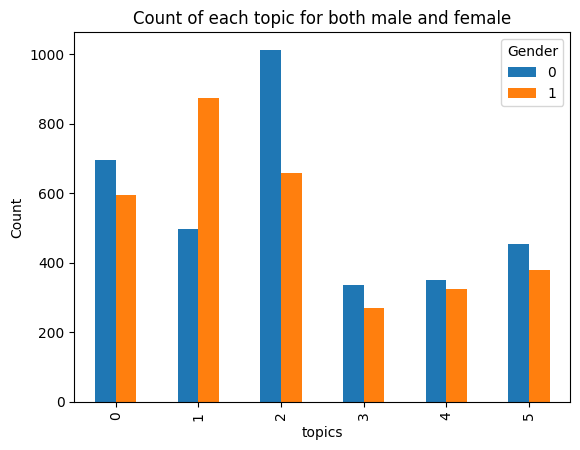

In [11]:
temp_data = correct_spelling_data
temp_data[1] = list(map(str, temp_data[1]))
grouped_words,dominate_topics1 = create_dominant_topics(temp_data[0], 6, 2)
plot_gender_topic_counts(temp_data, dominate_topics1)

In [12]:
for i in range(len(columns[0])):
    columns[0][i] = clean_text(columns[0][i])
    
print(columns[0][1])

Guest Demo Eric Iverson Itty Bitty Search February 16th 2010 Daniel Tunkelang Respond I back vacation still digging way everything piled I offline While I catch I thought I share demo Eric Iverson gracious enough share It uses Yahoo BOSS support exploratory search experience top general web search engine When perform query application retrieves set related term candidates using Yahoo key terms API It scores term dividing occurrence count within result set global occurrence relevance measure similar one former colleagues I used Endeca enterprise contexts You try demo http While rough edges produces nice considering simplicity approach Here example I used application explore learn something new I started information retrieval I noticed interactive information retrieval top term I used refine Most refinement suggestions looked familiar unfamiliar name caught attention Anton Leuski Following curiosity I refined Looking results I immediately saw Leuski done work evaluating document clusteri

In [7]:
blog_train, blog_test, gender_train, gender_test = train_test_split(columns[0], columns[1], test_size=0.2, random_state=42)
top_unigrams = common_grams(blog_train, 1, 1000, no_stopwords=True)

uni_bag = bag(top_unigrams)
uni_id = get_gram_id(uni_bag)

X = [feat_cnt(t, uni_bag, uni_id, 1, no_stopwords=False) for t in columns[0]]
X = constant([X])
y = [1 if (d == 'M' or d == 'm') else 0 for d in columns[1]] 

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)
run_models(X,y,"multinomial")
ensemble(X,y)

Naive Bayes Average cross-validation accuracy: 0.64506
Logistic Regression Average cross-validation accuracy: 0.62584
Ensemble cross-validation accuracy: 0.65064


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
documents = ['This is the first document.', 'This document is the second document.', 'And this is the third one.', 'Is this the first document?']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(correct_spelling_data[0])
X_array = X.toarray()
print(X)


  (0, 16141)	2
  (0, 27876)	1
  (0, 24119)	2
  (0, 15907)	2
  (0, 1482)	1
  (0, 23090)	1
  (0, 23937)	1
  (0, 6662)	1
  (0, 27885)	1
  (0, 4167)	2
  (0, 18097)	1
  (0, 26238)	2
  (0, 14965)	1
  (0, 29363)	1
  (0, 17077)	1
  (0, 23625)	1
  (0, 13038)	1
  (0, 20480)	1
  (0, 19504)	2
  (0, 28163)	2
  (0, 6410)	1
  (0, 30711)	1
  (0, 9882)	1
  (0, 2895)	1
  (0, 19592)	1
  :	:
  (3225, 732)	1
  (3225, 26428)	1
  (3225, 6391)	1
  (3225, 29031)	1
  (3225, 24288)	1
  (3225, 20356)	1
  (3225, 2435)	1
  (3225, 16206)	1
  (3225, 19514)	1
  (3225, 4066)	1
  (3225, 29420)	2
  (3225, 7812)	1
  (3225, 7907)	1
  (3225, 26676)	1
  (3225, 18218)	2
  (3225, 22339)	1
  (3225, 7304)	1
  (3225, 27663)	1
  (3225, 4160)	2
  (3225, 17124)	1
  (3225, 22558)	1
  (3225, 12867)	1
  (3225, 24692)	1
  (3225, 8450)	1
  (3225, 934)	1


In [ ]:
run_models(X, y, "multinomial")

Naive Bayes Average cross-validation accuracy: 0.68227
Logistic Regression Average cross-validation accuracy: 0.65996


(<3226x30809 sparse matrix of type '<class 'numpy.int64'>'
 	with 442660 stored elements in Compressed Sparse Row format>,
 [1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  

<bound method spmatrix.get_shape of <3226x30514 sparse matrix of type '<class 'numpy.float64'>'
	with 371966 stored elements in Compressed Sparse Row format>>


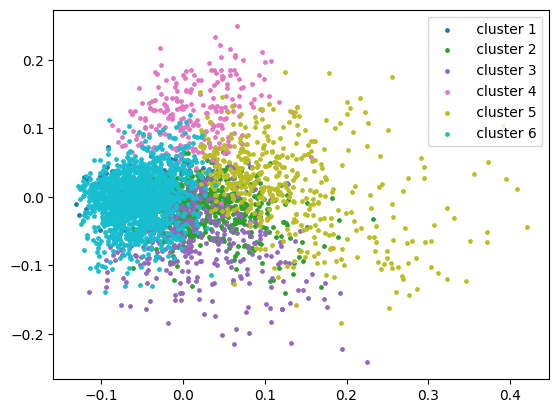

In [ ]:
clustered_data = cluster(correct_spelling_data[0], 6,2,True)

In [ ]:
print(clustered_data)

[[6], [3], [2], [6], [2], [6], [2], [5], [6], [2], [2], [5], [6], [2], [4], [6], [2], [5], [5], [2], [6], [2], [6], [3], [2], [6], [6], [6], [6], [3], [4], [6], [3], [3], [3], [2], [6], [6], [2], [6], [6], [6], [5], [6], [6], [6], [6], [3], [3], [2], [2], [6], [5], [2], [2], [3], [3], [2], [6], [6], [5], [5], [2], [2], [2], [2], [6], [5], [5], [6], [3], [2], [3], [2], [2], [6], [2], [2], [2], [5], [6], [5], [6], [4], [2], [3], [2], [3], [2], [2], [5], [5], [5], [6], [2], [6], [4], [6], [2], [5], [1], [6], [2], [2], [6], [2], [3], [3], [5], [3], [5], [6], [6], [1], [5], [2], [6], [3], [2], [6], [6], [2], [2], [5], [5], [2], [6], [5], [5], [3], [2], [3], [6], [3], [3], [6], [6], [5], [2], [2], [3], [5], [3], [2], [6], [6], [2], [6], [3], [2], [2], [2], [5], [5], [1], [3], [4], [6], [2], [6], [5], [2], [3], [3], [2], [2], [5], [6], [3], [6], [5], [2], [2], [4], [6], [2], [6], [3], [3], [6], [6], [6], [6], [3], [6], [5], [2], [6], [3], [6], [6], [6], [3], [3], [5], [3], [2], [2], [5], [6],

In [ ]:
maxNB, maxLog = 0, 0
for i in range(1,30):
  print("Total topics: {}".format(i)) 
  _,_,scoreNB, scoreLog = run_models(cluster(correct_spelling_data[0], i,2,False),correct_spelling_data[1],"gaussian")
  maxNB = max(maxNB, scoreNB)
  maxLog = max(maxLog, scoreLog)
print("Max NB: {:.5f} Max Log: {:.5f}".format(maxNB, maxLog))

Total topics: 1
<bound method spmatrix.get_shape of <3226x30514 sparse matrix of type '<class 'numpy.float64'>'
	with 371966 stored elements in Compressed Sparse Row format>>


C:\Users\danhj\AppData\Roaming\Python\Python312\site-packages\sklearn\naive_bayes.py:510: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
C:\Users\danhj\AppData\Roaming\Python\Python312\site-packages\sklearn\naive_bayes.py:511: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
C:\Users\danhj\AppData\Roaming\Python\Python312\site-packages\sklearn\naive_bayes.py:510: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
C:\Users\danhj\AppData\Roaming\Python\Python312\site-packages\sklearn\naive_bayes.py:511: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
C:\Users\danhj\AppData\Roaming\Python\Python312\site-packages\sklearn\naive_bayes.py:510: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * 

Naive Bayes Average cross-validation accuracy: 0.51922
Logistic Regression Average cross-validation accuracy: 0.51922
Total topics: 2
<bound method spmatrix.get_shape of <3226x30514 sparse matrix of type '<class 'numpy.float64'>'
	with 371966 stored elements in Compressed Sparse Row format>>
Naive Bayes Average cross-validation accuracy: 0.53723
Logistic Regression Average cross-validation accuracy: 0.53723
Total topics: 3
<bound method spmatrix.get_shape of <3226x30514 sparse matrix of type '<class 'numpy.float64'>'
	with 371966 stored elements in Compressed Sparse Row format>>
Naive Bayes Average cross-validation accuracy: 0.53754
Logistic Regression Average cross-validation accuracy: 0.53754
Total topics: 4
<bound method spmatrix.get_shape of <3226x30514 sparse matrix of type '<class 'numpy.float64'>'
	with 371966 stored elements in Compressed Sparse Row format>>
Naive Bayes Average cross-validation accuracy: 0.55488
Logistic Regression Average cross-validation accuracy: 0.48637
Tot

In [ ]:
#cluster total topic  = 22, gaussian
#cluster total topic = 22, Logistic Regression
#cluster total topic = 22, SVC
#factor anylysys: total topic = 6, most frequent = 2, gaussian
#factor anylysis: total topic = 6, most frequent = 2, Logistic Regression
#factor anylysis: total topic = 6, most frequent = 2, SVC
#total topic = 6, count frequncy,multinomialNB: 
